In [1]:
# import packages
import pandas as pd
import pyarrow.dataset as ds
from datasets import Dataset
import pyarrow as pa
from datasets import *
from transformers import *
from tokenizers import *
import os
import json
import sys
from tokenizers.processors import BertProcessing
import numpy as np

C:\Users\XinZhou\anaconda3\envs\dna\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\XinZhou\anaconda3\envs\dna\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [74]:
# loading for different datasets

MAX_LENGTH = 512
batch_size = 8
num_epochs = 5
max_step_saves = 3
test_only = False
data_name = 'mvdsc' # poj, devign, draper, d2a, mvdsc, sysevr
truncate_longer_samples = True
# is_windows = sys.platform.startswith('win')
# if is_windows:

data_dir = "..\\..\\cbert\\dna_data_rename_tag"
out_dir = 'result_{}'.format(data_name)

bert_model_path = '..\\..\\cbert\\pretrained\\test_albert_NaCUT\\checkpoint'
tokenizer_path = '..\\..\\cbert\\pretrained\\test_albert_NaCUT\\tokenizer.model'

# bert_model_path = 'albert-base-v2'
# tokenizer_path = 'albert-base-v2'

# load data
def get_data(file_path):
    raw_df = pd.read_pickle(file_path)  
    df = {'filename': [], 'text': [], 'label': []}
    for i in range(len(raw_df['code'])):
        df['filename'].append(raw_df['filename'][i])
        code = raw_df['code'][i].split(';')
        code = ' '.join(code)
        df['text'].append(code)
        df['label'].append(raw_df['label'][i])
    df = pd.DataFrame(df)
    return df

# train_data = get_data('/scratch/xin/bert_source/mvdsc/tokenized_mvdsc_train.pkl')
# valid_data = get_data('/scratch/xin/bert_source/mvdsc/tokenized_mvdsc_valid.pkl')
if data_name == 'devign':
    raw_data_path = os.path.join(data_dir, data_name, 'devign_all.pkl')
    tokenized_data = get_data(raw_data_path)
    train_data, valid_data, test_data = np.split(tokenized_data.sample(frac=1, random_state=2022), 
                   [int(.8*len(tokenized_data)), int(.9*len(tokenized_data))])
elif data_name == 'mvdsc':
    raw_data_path = os.path.join(data_dir, data_name, 'mvdsc_train.pkl')
    train_data = get_data(raw_data_path)
    raw_data_path = os.path.join(data_dir, data_name, 'mvdsc_valid.pkl')
    valid_data = get_data(raw_data_path)
    raw_data_path = os.path.join(data_dir, data_name, 'mvdsc_test.pkl')
    test_data = get_data(raw_data_path)
    

from sklearn.model_selection import train_test_split
train_data = train_data[:2000]
valid_data = valid_data[:500]
test_data = test_data[:500]

# print(train_data.shape)
# print(valid_data.shape)
# print(test_data.shape)
# print(train_data['text'][:10])

In [75]:
label_counts = pd.DataFrame(train_data['label'].value_counts())
label_counts
label_values = list(label_counts.index)
order = list(pd.DataFrame(train_data['label'].value_counts()).index)
label_values = [l for _,l in sorted(zip(order, label_values))]
label_values

[0, 1]

In [76]:
train_texts = train_data['text'].values
train_labels = train_data['label'].values

valid_texts = valid_data['text'].values
valid_labels = valid_data['label'].values

test_texts = test_data['text'].values
test_labels = test_data['label'].values


print(len(train_texts), len(train_labels))

2000 2000


In [77]:
import statistics
train_texts[0]
text_lengths = [len(train_texts[i].split()) for i in range(len(train_texts))]
print('min: ', min(text_lengths))
print('number of zeros: ', len([item for item in text_lengths if item == 0]))
print('max: ', max(sorted(text_lengths)))
print('avg: ', sum(text_lengths) / len(text_lengths))
print('median: ', sorted(text_lengths)[len(text_lengths) // 2])
print('95%: ', sorted(text_lengths)[int(len(text_lengths)*0.95)])
print(statistics.mean(text_lengths))
print(statistics.stdev(text_lengths))

min:  94
number of zeros:  0
max:  1641
avg:  829.0135
median:  823
95%:  1504
829.0135
432.5954434880392


C:\Users\XinZhou\AppData\Local\Temp\ipykernel_16296\2095679928.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(text_lengths, hist=True, kde=False,


Text(0, 0.5, 'counts')

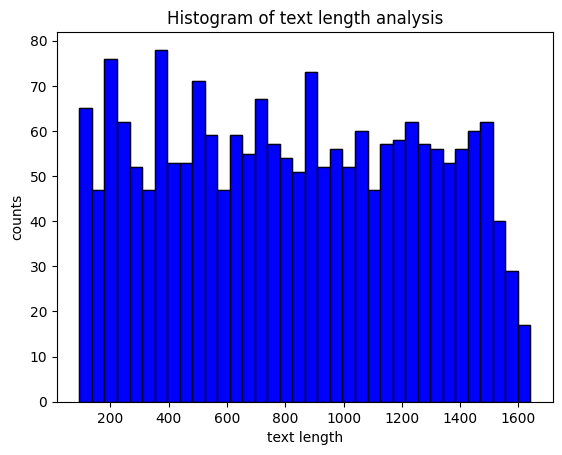

In [78]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns
# matplotlib histogram
plt.hist(text_lengths, color = 'blue', edgecolor = 'black',
         bins = int(180/5))
# seaborn histogram
sns.distplot(text_lengths, hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of text length analysis')
plt.xlabel('text length')
plt.ylabel('counts')

In [79]:
sum([1 for i in range(len(text_lengths)) if text_lengths[i] >= MAX_LENGTH])

1422

In [80]:
# ========================= load tokenizer START =========================
# 30,522 vocab is BERT's default vocab size, feel free to tweak
# vocab_size = 30000
import transformers
import sentencepiece as spm
# maximum sequence length, lowering will result to faster training (when increasing batch size)
# max_length = 512 # 768
# from transformers import RobertaTokenizerFast
print('tokenizer_path: ', tokenizer_path)
# tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_path, max_len=512)
tokenizer = transformers.AlbertTokenizer.from_pretrained(tokenizer_path)
print('tokenizer loaded ...')
# ========================= load tokenizer END =========================

sys.exit(0)

C:\Users\XinZhou\anaconda3\envs\dna\lib\site-packages\transformers\tokenization_utils_base.py:1653: FutureWarning: Calling AlbertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(
loading file ..\..\cbert\pretrained\test_albert_NaCUT\tokenizer.model
Adding [CLS] to the vocabulary
Adding [SEP] to the vocabulary
Adding <pad> to the vocabulary
Adding [MASK] to the vocabulary
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


tokenizer loaded ...


In [82]:
# text_ids = [tokenizer.encode(text, max_length=300, pad_to_max_length=True) for text in texts]
if not truncate_longer_samples:
    #tokenizer(examples["text"], return_special_tokens_mask=True)
    train_text_dict = [tokenizer(t, return_special_tokens_mask=True) for t in train_texts]
    valid_text_dict = [tokenizer(t, return_special_tokens_mask=True) for t in valid_texts]
    test_text_dict = [tokenizer(t, return_special_tokens_mask=True) for t in test_texts]
else:
    max_length = MAX_LENGTH
    train_text_dict = [tokenizer(t, truncation=True, padding='max_length', max_length=max_length, return_special_tokens_mask=True) for t in train_texts]
    valid_text_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=max_length, return_special_tokens_mask=True) for t in valid_texts]
    test_text_dict = [tokenizer(t, truncation=True, padding="max_length", max_length=max_length, return_special_tokens_mask=True) for t in test_texts]

In [83]:
train_text_ids = [text_id['input_ids'] for text_id in train_text_dict]
valid_text_ids = [text_id['input_ids'] for text_id in valid_text_dict]
test_text_ids = [text_id['input_ids'] for text_id in test_text_dict]
# print(train_text_ids[10])

train_att_masks = [text_id['attention_mask'] for text_id in train_text_dict]
valid_att_masks = [text_id['attention_mask'] for text_id in valid_text_dict]
test_att_masks = [text_id['attention_mask'] for text_id in test_text_dict]
# test_att_masks

In [84]:
from sklearn.model_selection import train_test_split
train_x, train_m, train_y = train_text_ids, train_att_masks, train_labels
val_x, val_m, val_y = valid_text_ids, valid_att_masks, valid_labels
test_x, test_m, test_y = test_text_ids, test_att_masks, test_labels

In [85]:
import torch

train_x = torch.tensor(train_x)
test_x = torch.tensor(test_x)
val_x = torch.tensor(val_x)
train_y = torch.tensor(train_y)
test_y = torch.tensor(test_y)
val_y = torch.tensor(val_y)
train_m = torch.tensor(train_m)
test_m = torch.tensor(test_m)
val_m = torch.tensor(val_m)

# print(train_x.shape)
# print(test_x.shape)
# print(val_x.shape)
# print(train_y.shape)
# print(test_y.shape)
# print(val_y.shape)
# print(train_m.shape)
# print(test_m.shape)
# print(val_m.shape)

In [86]:
import torch.nn as nn
import torch
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
import sys
from transformers import RobertaForMaskedLM
import transformers



class BERTSourceBinaryClassification(nn.Module):
    def __init__(self,checkpoint, num_labels): 
        super(BERTSourceBinaryClassification,self).__init__() 
        self.num_labels = num_labels 
        #print(num_labels)
        hidden_features = 768
        # config = AutoConfig.from_pretrained(checkpoint, output_hidden_states=True, output_attentions=True)
        #self.model = AutoModel.from_pretrained(checkpoint, config=config)
        config = AutoConfig.from_pretrained(checkpoint, output_attentions=True)
        self.model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config, num_labels=2)
   
    def forward_single(self, input_ids, labels):
        outputs  = self.model(input_ids)
        # hidden_states, pool_output, unknown, attention_weights
        pooled_output = outputs[1]
        attention_weights = outputs[-1][0]
        return pooled_output, attention_weights
    
    
    def forward(self, input_ids=None, labels=None,  max_len=MAX_LENGTH):
        final_out  = self.model(input_ids)
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(final_out.view(-1, self.num_labels), labels.view(-1))
        return (loss, final_out), attention_weights_all
    
    
    
# class BERTSourceBinaryClassification(nn.Module):
#     def __init__(self,checkpoint, num_labels): 
#         super(BERTSourceBinaryClassification,self).__init__() 
#         self.num_labels = num_labels 
#         #print(num_labels)
#         hidden_features = 768
#         config = AutoConfig.from_pretrained(checkpoint, output_hidden_states=True, output_attentions=True)
#         self.model = AutoModel.from_pretrained(checkpoint, config=config)
#         #self.model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=hidden_features)
#         #print(self.model)
#         #print(self.model.config)
#         self.dropout = nn.Dropout(0.1)
#         self.classifier = nn.Linear(hidden_features * 1 * MAX_LENGTH//512, num_labels) # load and initialize weights
#         #self.sigmoid = nn.Sigmoid()
    
#     def forward_single(self, input_ids, labels):
#         outputs  = self.model(input_ids)
#         # hidden_states, pool_output, unknown, attention_weights
#         pooled_output = outputs[1]
#         attention_weights = outputs[-1][0]
#         return pooled_output, attention_weights
    
    
#     def forward(self, input_ids=None, labels=None,  max_len=MAX_LENGTH):
#         #Extract outputs from the body
#         final_logits = None
#         final_attention_weights = None
#         # pick the most suspicous one for final decision
#         last_all = None
#         attn_all = None
#         attention_weights_all = None
#         for i in range(0, max_len, 512):
#             last, attention_weights = self.forward_single(input_ids[:,i:i+512], labels)
#             if last_all is None:
#                 last_all = last
#                 attention_weights_all = attention_weights
#             else:
#                 last_all = torch.cat([last_all,  last_all], dim=1)
#                 attention_weights_all = torch.cat([attention_weights_all,  attention_weights], dim=-1)
                
#         final_out = self.dropout(last_all)
#         final_out = self.classifier(final_out)
#         loss = None
#         if labels is not None:
#             loss_fct = nn.CrossEntropyLoss()
#             loss = loss_fct(final_out.view(-1, self.num_labels), labels.view(-1))
#         return (loss, final_out), attention_weights_all



In [87]:
# from transformers import DistilBertForSequenceClassification, AdamW, DistilBertConfig
# num_labels = len(set(labels))
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels,
#                                                             output_attentions=False, output_hidden_states=False)

# model_path = os.path.join(bert_dir, "checkpoint-60000")
print(bert_model_path)
model = BERTSourceBinaryClassification(checkpoint=bert_model_path, num_labels=2)

import torch.optim as optim

learning_rate = 1e-4
adam_epsilon = 1e-6

no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0001},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
# optimizer = optim.Adam(model.parameters, lr=learning_rate)

# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
multi_gpu = torch.cuda.device_count() 
print(multi_gpu)
if multi_gpu > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
# model = nn.DataParallel(model)

# optimizer = optim.Adam(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
model = model.cuda()
# sys.exit(0)




loading configuration file ..\..\cbert\pretrained\test_albert_NaCUT\checkpoint\config.json
Model config AlbertConfig {
  "_name_or_path": "..\\..\\cbert\\pretrained\\test_albert_NaCUT\\checkpoint",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 8192,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "output_attentions": true,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "vocab_size": 32010
}

loading weights file ..\..\cbert\pretrained\test_

..\..\cbert\pretrained\test_albert_NaCUT\checkpoint
1


C:\Users\XinZhou\anaconda3\envs\dna\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [88]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

print(train_x)
train_data = TensorDataset(train_x, train_m, train_y)
train_sampler = list(range(len(train_data)))

# train_sampler = train_sampler[:100]
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_x, val_m, val_y)
val_sampler = list(range(len(val_data)))
# val_sampler = val_sampler[:100]
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

from transformers import get_linear_schedule_with_warmup

total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


tensor([[32000,    50,     3,  ...,     3,    15, 32001],
        [32000,    50,     3,  ...,   136,   145, 32001],
        [32000,    50,     3,  ...,    41,     3, 32001],
        ...,
        [32000,    50,     3,  ..., 32002, 32002, 32002],
        [32000,    50,     3,  ..., 32002, 32002, 32002],
        [32000,    50,     3,  ...,    43,    22, 32001]])


In [89]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

import numpy as np
import random

seed_val = 111
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

import pickle
import os

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
# save model 

def save_model(model, train_losses, val_losses, out_dir_model):

    if not os.path.exists(out_dir_model):
        os.makedirs(out_dir_model)
    
    PATH = os.path.join(out_dir_model, 'BERTSourceBinaryClassification.pt')

    torch.save(model.state_dict(), PATH)

    with open(out_dir_model + '/train_losses.pkl', 'wb') as f:
        pickle.dump(train_losses, f)

    with open(out_dir_model + '/val_losses.pkl', 'wb') as f:
        pickle.dump(val_losses, f)

save_step_at = len(train_dataloader)
print('number of iterations: ', len(train_dataloader))


number of iterations:  250


In [ ]:
model.train()

if not test_only:
    from tqdm import tqdm
    train_losses = []
    val_losses = []
    num_mb_train = len(train_dataloader)
    num_mb_val = len(val_dataloader)
    current_step = 0
    saved_steps = []
    if num_mb_val == 0:
        num_mb_val = 1

    # print('number of iterations: ', len(train_dataloader), len(train_loader_extracted))
    print('num_epochs: ', num_epochs)

    loss_fct = nn.CrossEntropyLoss()

    for n in range(num_epochs):
        train_loss = 0
        val_loss = 0
        start_time = time.time()
        #for k, (data1, data2) in enumerate(zip(train_dataloader, train_loader_extracted)):
        for k, (mb_x, _, mb_y) in tqdm(enumerate(train_dataloader)):
            optimizer.zero_grad()
            
            mb_x = mb_x.cuda()
            mb_y = mb_y.cuda()
            outputs, _, = model(mb_x, labels=mb_y)

            loss = outputs[0]

            if multi_gpu > 1:
                loss = loss.sum()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            current_step += 1
            train_loss += loss.data / num_mb_train

            if current_step % save_step_at == 0:
                saved_steps.append(current_step)
                out_dir_model = './{}/classification_model_{}'.format(out_dir, saved_steps[-1])
                print('saved as: ', out_dir_model)
                if len(saved_steps) > max_step_saves:
                    delete_dir = './{}/classification_model_{}'.format(out_dir, saved_steps[-(max_step_saves+1)])
                    os.system('rm -r {}'.format(delete_dir))
                save_model(model, train_losses, val_losses, out_dir_model)


        print ("\nTrain loss after itaration %i: %f" % (n+1, train_loss))
        train_losses.append(train_loss.cpu())

        with torch.no_grad():
            model.eval()

            for k, (mb_x, _, mb_y) in enumerate(val_dataloader):
                mb_x = mb_x.cuda()
                #mb_m = mb_m.cuda()
                mb_y = mb_y.cuda()

                outputs, _ = model(mb_x,  labels=mb_y)
                loss = outputs[0]
                if multi_gpu > 1:
                    loss = loss.sum()
                #loss = model_loss(outputs[1], mb_y)

                val_loss += loss.data / num_mb_val

            print ("Validation loss after itaration %i: %f" % (n+1, val_loss))
            # save the best
            print('val_losses: ', val_losses, float(val_loss.cpu()))
            if val_losses and float(val_loss.cpu()) <= min(val_losses):
                out_dir_model = './{}/classification_model_best'.format(out_dir)
                print('the best model updated')
                print('saved as: ', out_dir_model)
                save_model(model, train_losses, val_losses, out_dir_model)
            val_losses.append(float(val_loss.cpu()))

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Time: {epoch_mins}m {epoch_secs}s')
        if len(val_losses) > 3 and float(val_loss.cpu()) > max(val_losses[-4:-1]):
            break

num_epochs:  5


250it [01:34,  2.64it/s]



Train loss after itaration 1: 0.721928
Validation loss after itaration 1: 0.695310
val_losses:  [] 0.6953104734420776
Time: 1m 43s


249it [01:38,  2.46it/s]

saved as:  ./result_mvdsc/classification_model_500


250it [01:39,  2.50it/s]



Train loss after itaration 2: 0.715457
Validation loss after itaration 2: 0.736774
val_losses:  [0.6953104734420776] 0.7367736101150513
Time: 1m 49s


250it [01:40,  2.49it/s]



Train loss after itaration 3: 0.697116
Validation loss after itaration 3: 0.695616
val_losses:  [0.6953104734420776, 0.7367736101150513] 0.6956155300140381
Time: 1m 49s


249it [01:38,  2.61it/s]

saved as:  ./result_mvdsc/classification_model_1000


250it [01:39,  2.51it/s]



Train loss after itaration 4: 0.695342
Validation loss after itaration 4: 0.693732
val_losses:  [0.6953104734420776, 0.7367736101150513, 0.6956155300140381] 0.693731963634491
the best model updated
saved as:  ./result_mvdsc/classification_model_best
Time: 1m 48s


219it [01:23,  2.61it/s]

[0.9171069264411926, 0.6922087073326111, 0.6870942115783691, 0.714285671710968]


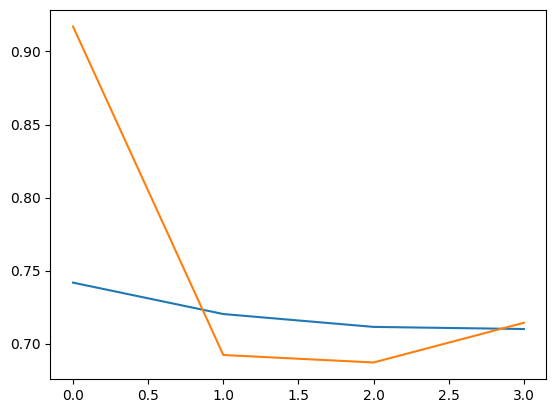

In [69]:

# out_dir_model = '{}/classification_model_4000'.format(out_dir)

test_dir_model = '{}/classification_model_1250'.format(out_dir)

PATH = os.path.join(test_dir_model, 'BERTSourceBinaryClassification.pt')
model.load_state_dict(torch.load(PATH))
model.eval()

with open(test_dir_model + '/train_losses.pkl', 'rb') as f:
    train_losses = pickle.load(f)
    
with open(test_dir_model + '/val_losses.pkl', 'rb') as f:
    val_losses = pickle.load(f)

print(val_losses)
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)

In [70]:
from tqdm import tqdm
# test_data = test_data[:100]
test_data = TensorDataset(test_x, test_m)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


outputs = []
print('num of iterations: ', len(test_dataloader))
with torch.no_grad():
    for k, (mb_x, _) in tqdm(enumerate(test_dataloader)):
        mb_x = mb_x.cuda()
        #mb_m = mb_m.cuda()
        output, attention_weights = model(mb_x)
        outputs.append(output[1].to('cpu'))


num of iterations:  50


50it [00:02, 22.17it/s]


In [71]:
outputs = torch.cat(outputs)
# print(outputs)
_, predicted_values = torch.max(outputs, 1)
predicted_values = predicted_values.numpy()
true_values = test_y.numpy()

test_accuracy = np.sum(predicted_values == true_values) / len(true_values)
print ("Test Accuracy:", test_accuracy)


Test Accuracy: 0.55


In [72]:
import itertools

# plot confusion matrix
# code borrowed from scikit-learn.org
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[55  0]
 [45  0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


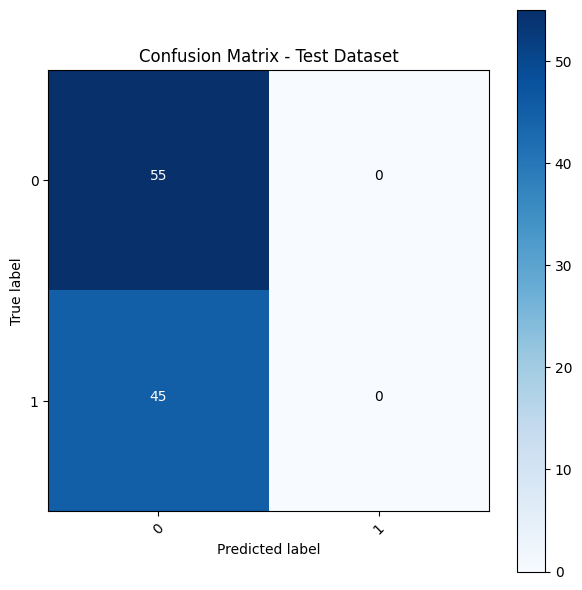

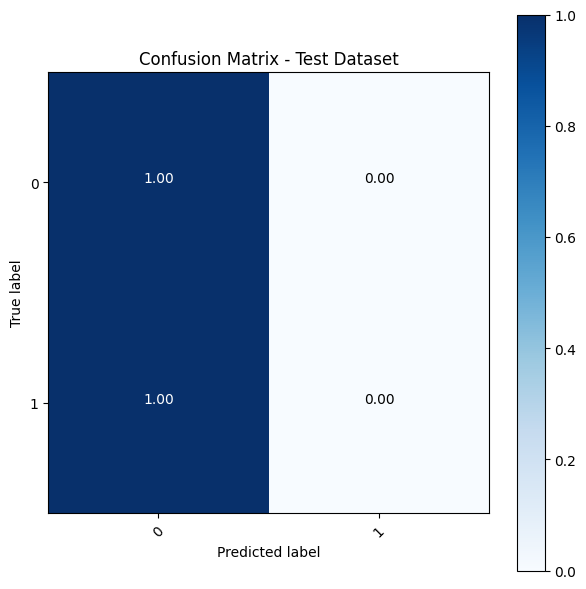

In [73]:
from sklearn.metrics import classification_report, confusion_matrix

cm_test = confusion_matrix(true_values, predicted_values)

np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset')
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset', normalize=True)

In [29]:

from bertviz import model_view
from tqdm import tqdm
# test_data = test_data[:100]
test_data = TensorDataset(test_x, test_m)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


outputs = []
print('num of iterations: ', len(test_dataloader))
with torch.no_grad():
    for k, (mb_x, _) in tqdm(enumerate(test_dataloader)):
        mb_x = mb_x.cuda()
        output, attention_weights = model(mb_x)
        outputs.append(output[1].to('cpu'))
        break

# train_text_ids = [text_id['input_ids'] for text_id in train_text_dict]
# valid_text_ids = [text_id['input_ids'] for text_id in valid_text_dict]
# test_text_ids = [text_id['input_ids'] for text_id in test_text_dict]

# train_att_masks = [text_id['attention_mask'] for text_id in train_text_dict]
# valid_att_masks = [text_id['attention_mask'] for text_id in valid_text_dict]
# test_att_masks = [text_id['attention_mask'] for text_id in test_text_dict]
# train_texts = train_data['text'].values
# train_labels = train_data['label'].values

sample_index = 11
print('original code: ', train_texts[sample_index], len(train_texts[sample_index]))
print('label: ', train_labels[sample_index])
# print(train_text_ids[sample_index], len(train_text_ids[sample_index]))
input_text = train_text_ids[sample_index]

# # print(attention_weights.shape)
# attn_weights = attention_weights[0][-1]
# attn_weights = torch.sum(attn_weights, 0)
# # attn_weights = attn_weights[-1]
# print(attn_weights.shape)
tokens = tokenizer.convert_ids_to_tokens(input_text)  # Convert input ids to token strings
# print(tokens)
# print(len(tokens), len(attn_weights))
# tokens = tokens
# attn_weights = attn_weights
# # print(attn_weights[:200])

num of iterations:  13


0it [00:00, ?it/s]

original code:  translation_unit void function_declarator CWE121_Stack_Based_Buffer_Overflow__src_char_declare_cpy_01_bad argument_list ( ) compound_statement { declaration char pointer_declarator * expression_statement charPointerDefUsePass   declaration char array_declarator charDefCall [ number_literal 8 9 5 ]   expression_statement charPointerDefUsePass = array_declarator charDefCall   expression_statement memset argument_list ( expression_statement charPointerDefUsePass , char_literal ' ERROR A char_literal ' , number_literal 3 1 6 )   expression_statement charPointerDefUsePass [ number_literal 6 5 7 ] = char_literal ' escape_sequence \0 char_literal '   expression_statement charPointerDefUsePass [ number_literal 6 3 5 ] = char_literal ' char_literal '   expression_statement charPointerDefUsePass [ number_literal 5 9 6 ] = char_literal ' char_literal '   declaration char init_declarator charDefPass [ number_literal 1 4 5 ] = string_literal " "   expression_statement strcpy argumen

In [30]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt




def colorize(words, color_array):
    cmap=matplotlib.cm.Blues
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_string = ''
    for i, (word, color) in enumerate(zip(words, color_array)):
        if word == '[PAD]' or 'unused' in word or word == '<pad>':
            continue
        color = matplotlib.colors.rgb2hex(cmap(color)[:3])
        #print(color)
        if not word.isascii():
            continue
        if i % 20 == 0:
            colored_string += template.format(color, '&nbsp' + str(word)  + '&nbsp <br>')
        else:
            colored_string += template.format(color, '&nbsp' + str(word)  + '&nbsp')
    return colored_string

# words = 'The quick brown fox jumps over the lazy dog'.split()
words = tokens
# print(words)
color_array = np.random.rand(len(words))
s = colorize(words, color_array)


# or simply save in an html file and open in browser
with open('colorize.html', 'w') as f:
    f.write(s)

In [208]:

# from bertviz import model_view
# from tqdm import tqdm
# # test_data = test_data[:100]
# test_data = TensorDataset(test_x, test_m)
# test_sampler = SequentialSampler(test_data)
# test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


# outputs = []
# print('num of iterations: ', len(test_dataloader))
# with torch.no_grad():
#     for k, (mb_x, mb_m) in tqdm(enumerate(test_dataloader)):
#         mb_x = mb_x.cuda()
#         mb_m = mb_m.cuda()
#         output, attention_weights = model(mb_x, attention_mask=mb_m, max_len=MAX_LENGTH, opt='mean')
#         outputs.append(output[1].to('cpu'))
#         break
        

# # from transformers import AutoTokenizer, AutoModel, utils
# # from bertviz import model_view
# # utils.logging.set_verbosity_error()  # Suppress standard warnings

# # model_name = "microsoft/xtremedistil-l12-h384-uncased"  # Find popular HuggingFace models here: https://huggingface.co/models
# # input_text = "The cat sat on the mat"  
# # model = AutoModel.from_pretrained(model_name, output_attentions=True)  # Configure model to return attention values
# # tokenizer = AutoTokenizer.from_pretrained(model_name)
# # inputs = tokenizer.encode(input_text, return_tensors='pt')  # Tokenize input text
# # outputs = model(inputs)  # Run model
# # attention = outputs[-1]  # Retrieve attention from model outputs
# # tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings
# # model_view(attention, tokens)  # Display model view

TypeError: max() received an invalid combination of arguments - got (list, int), but expected one of:
 * (Tensor input)
 * (Tensor input, Tensor other, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, tuple of Tensors out)
 * (Tensor input, name dim, bool keepdim, *, tuple of Tensors out)
